## Plot mutation prediction results

In this notebook, we'll visualize the results of our mutation prediction experiments, predicting a binary mutated/not mutated label for each gene (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
# TODO: may need to rerun these on only expression samples
# (i.e. without methylation data overlap)
vogelstein_results_dir = Path(cfg.results_dirs['mutation'],
                              'vogelstein_expression_only',
                              'gene').resolve()
top_50_results_dir = Path(cfg.results_dirs['mutation'],
                          'top_50_expression_only',
                          'gene').resolve()
random_50_results_dir = Path(cfg.results_dirs['mutation'],
                             '50_random_expression_only',
                             'gene').resolve()

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, save figures to ./images directory
SAVE_FIGS = True

In [3]:
# load raw data
vogelstein_df = au.load_stratified_prediction_results(vogelstein_results_dir, 'gene')
vogelstein_df = vogelstein_df[vogelstein_df.training_data.isin(['expression'])]
vogelstein_df['gene_set'] = 'vogelstein'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(vogelstein_df.shape)
print(vogelstein_df.seed.unique())
print(vogelstein_df.training_data.unique())
vogelstein_df.head()

(4920, 10)
[42  1]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,0.99386,0.93793,MAP3K1,expression,signal,42,train,0,gene,vogelstein
1,0.74244,0.34514,MAP3K1,expression,signal,42,test,0,gene,vogelstein
2,0.65156,0.20172,MAP3K1,expression,signal,42,cv,0,gene,vogelstein
3,0.99603,0.92337,MAP3K1,expression,signal,42,train,1,gene,vogelstein
4,0.66892,0.31002,MAP3K1,expression,signal,42,test,1,gene,vogelstein


In [4]:
# load raw data
top_50_df = au.load_stratified_prediction_results(top_50_results_dir, 'gene')
top_50_df = top_50_df[top_50_df.training_data.isin(['expression'])]
top_50_df['gene_set'] = 'top_50'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(top_50_df.shape)
print(top_50_df.seed.unique())
print(top_50_df.training_data.unique())
top_50_df.head()

(5136, 10)
[42  1]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,0.50544,0.47987,TP53,expression,shuffled,42,train,0,gene,top_50
1,0.52804,0.50126,TP53,expression,shuffled,42,test,0,gene,top_50
2,0.50844,0.48510,TP53,expression,shuffled,42,cv,0,gene,top_50
3,0.50000,0.48132,TP53,expression,shuffled,42,train,1,gene,top_50
4,0.50000,0.46177,TP53,expression,shuffled,42,test,1,gene,top_50


In [5]:
# load raw data
random_50_df = au.load_stratified_prediction_results(random_50_results_dir, 'gene')
random_50_df = random_50_df[random_50_df.training_data.isin(['expression'])]
random_50_df['gene_set'] = 'random_50'

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(random_50_df.shape)
print(random_50_df.seed.unique())
print(random_50_df.training_data.unique())
random_50_df.head()

(5136, 10)
[ 1 42]
['expression']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,gene_set
0,0.79660,0.293060,TMEM132D,expression,shuffled,1,train,0,gene,random_50
1,0.46214,0.076815,TMEM132D,expression,shuffled,1,test,0,gene,random_50
2,0.55997,0.074921,TMEM132D,expression,shuffled,1,cv,0,gene,random_50
3,0.59354,0.160430,TMEM132D,expression,shuffled,1,train,1,gene,random_50
4,0.49272,0.063990,TMEM132D,expression,shuffled,1,test,1,gene,random_50


In [6]:
# combine results dataframes
results_df = (
    pd.concat((vogelstein_df, top_50_df, random_50_df))
      .drop(columns=['training_data', 'experiment'])
)

# for each gene set, compare signal vs. shuffled + do statistical testing
all_results_df = pd.DataFrame()
for gene_set in results_df.gene_set.unique():
    gene_df = results_df[results_df.gene_set == gene_set].copy()
    gene_df.sort_values(by=['seed', 'fold'], inplace=True)
    data_results_df = au.compare_results(gene_df,
                                         identifier='identifier',
                                         metric='aupr',
                                         correction=True,
                                         correction_method='fdr_bh',
                                         correction_alpha=SIG_ALPHA,
                                         verbose=True)
    data_results_df['gene_set'] = gene_set
    data_results_df.rename(columns={'identifier': 'gene'}, inplace=True)
    all_results_df = pd.concat((all_results_df, data_results_df))
    
all_results_df.sort_values(by='gene_set', inplace=True)
all_results_df.sort_values(by='p_value').head(10)

shapes unequal for CBL, skipping
shapes unequal for CDC73, skipping
shapes unequal for MLH1, skipping
shapes unequal for MPL, skipping
shapes unequal for MSH2, skipping
shapes unequal for PAX5, skipping
shapes unequal for PTPN11, skipping
shapes unequal for RUNX1, skipping


,gene,delta_mean,p_value,corr_pval,reject_null,gene_set
16,BRAF,0.617245,8.469952e-12,8.300552e-10,True,vogelstein
94,TP53,0.407729,2.752387e-11,1.348670e-09,True,vogelstein
29,EGFR,0.584966,6.212349e-11,2.029367e-09,True,vogelstein
26,CTNNB1,0.593111,9.130106e-11,2.236876e-09,True,vogelstein
97,TP53,0.403219,1.506934e-10,9.547347e-09,True,top_50
77,PIK3CA,0.336788,2.281060e-10,9.547347e-09,True,top_50
6,ARID1A,0.424040,2.593933e-10,5.084109e-09,True,vogelstein
5,APC,0.579734,2.676826e-10,9.547347e-09,True,top_50
31,CTNNB1,0.598305,5.723946e-10,2.548076e-08,True,random_50
7,APC,0.584286,6.521567e-10,2.548076e-08,True,random_50


random_50: 9/107 (0.0841)
top_50: 22/107 (0.2056)
vogelstein: 50/98 (0.5102)


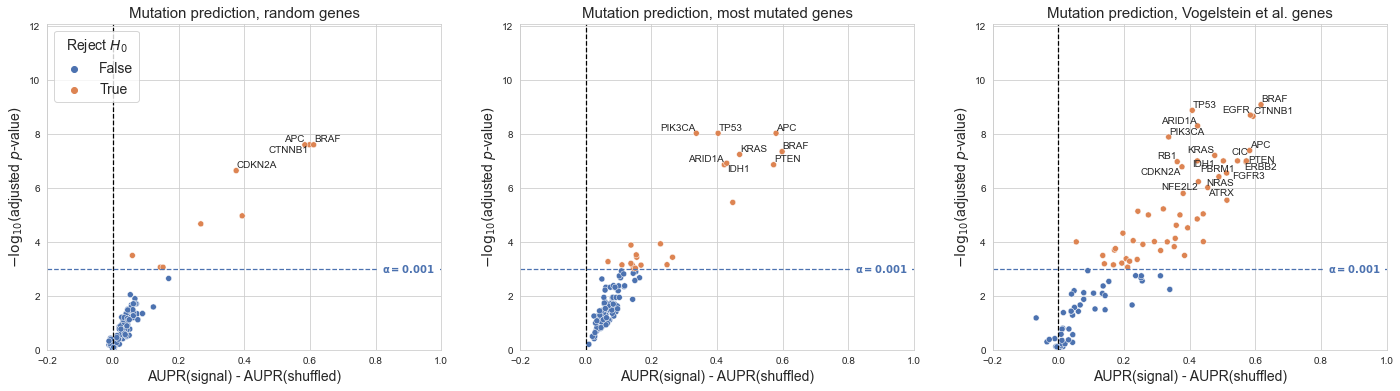

In [7]:
all_results_df['nlog10_p'] = -np.log10(all_results_df.corr_pval)

sns.set({'figure.figsize': (24, 6)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 3)

gene_set_map = {
    'top_50': 'most mutated',
    'random_50': 'random',
    'vogelstein': 'Vogelstein et al.'
}

# all plots should have the same axes for a fair comparison
xlim = (-0.2, 1.0)
y_max = all_results_df.nlog10_p.max()
ylim = (0, y_max+3)

# function to add gene labels to points
def label_points(x, y, gene, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene})
    for i, point in a.iterrows():
        if point['y'] > -np.log10(SIG_ALPHA / 1000):
            text_labels.append(
                ax.text(point['x'], point['y'], str(point['gene']))
            )
    return text_labels

# plot mutation prediction from expression, in a volcano-like plot
for ix, gene_set in enumerate(sorted(all_results_df.gene_set.unique())):
    ax = axarr[ix]
    data_results_df = all_results_df[all_results_df.gene_set == gene_set]
    sns.scatterplot(data=data_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                    hue_order=[False, True], ax=ax, legend=(ix == 0))
    # add vertical line at 0
    ax.axvline(x=0, linestyle='--', linewidth=1.25, color='black')
    # add horizontal line at statistical significance threshold
    l = ax.axhline(y=-np.log10(SIG_ALPHA), linestyle='--', linewidth=1.25)
    # label horizontal line with significance threshold
    # (matplotlib makes this fairly difficult, sadly)
    ax.text(0.9, -np.log10(SIG_ALPHA)+0.01,
            r'$\mathbf{{\alpha = {}}}$'.format(SIG_ALPHA),
            va='center', ha='center', color=l.get_color(),
            backgroundcolor=ax.get_facecolor())
    ax.set_xlabel('AUPR(signal) - AUPR(shuffled)', size=14)
    ax.set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$', size=14)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if ix == 0:
        ax.legend(title=r'Reject $H_0$', loc='upper left', fontsize=14, title_fontsize=14)
    ax.set_title(r'Mutation prediction, {} genes'.format(gene_set_map[gene_set]),
                 size=15)

    # label genes and adjust text to not overlap
    # automatic alignment isn't perfect, can align by hand in inkscape if necessary
    text_labels = label_points(data_results_df['delta_mean'],
                               data_results_df['nlog10_p'],
                               data_results_df.gene,
                               ax)
    
    adjust_text(text_labels,
                ax=ax, 
                expand_text=(1., 1.),
                lim=5)
    
    print('{}: {}/{} ({:.4f})'.format(
        gene_set,
        np.count_nonzero(data_results_df.reject_null),
        data_results_df.shape[0],
        np.count_nonzero(data_results_df.reject_null) / data_results_df.shape[0]
    ))
    
    
if SAVE_FIGS:
    images_dir = Path(cfg.images_dirs['mutation'])
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'expression_vs_shuffled.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'expression_vs_shuffled.png',
                dpi=300, bbox_inches='tight')

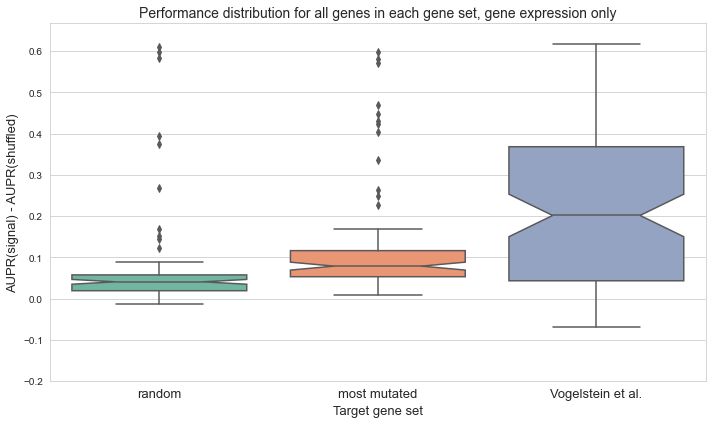

In [8]:
sns.set({'figure.figsize': (10, 6)})
sns.set_style('whitegrid')
# we want these colors to be different than the expression/methylation ones
sns.set_palette('Set2')
fig, axarr = plt.subplots(1, 1)

all_results_df.replace({'gene_set': gene_set_map}, inplace=True)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr
sns.boxplot(data=all_results_df, x='gene_set', y='delta_mean',
            notch=True, ax=ax)
ax.set_title('Performance distribution for all genes in each gene set, gene expression only', size=14)
ax.set_xlabel('Target gene set', size=13)
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)', size=13)
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))
for tick in ax.get_xticklabels():
    tick.set_fontsize(13)
    
plt.tight_layout()

if SAVE_FIGS:
    plt.savefig(images_dir / 'expression_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'expression_boxes.png',
                dpi=300, bbox_inches='tight')

(63,)
['CTNNB1' 'GPR98' 'APC' 'BRAF' 'CASP8' 'CDKN2A' 'SYNE1' 'KEAP1' 'NCOR1'
 'PIK3CA' 'NF1' 'MUC16' 'PTEN' 'USH2A' 'TTN' 'TP53' 'RYR2' 'RYR1' 'KRAS'
 'BAGE2' 'ATRX' 'ARID1A' 'IDH1' 'HUWE1' 'FAT3' 'DNAH7' 'DNAH5' 'FGFR3'
 'DNMT1' 'EGFR' 'ERBB2' 'FBXW7' 'FGFR2' 'GATA3' 'FUBP1' 'GNAS' 'H3F3A'
 'FLT3' 'HRAS' 'BAP1' 'CARD11' 'CDH1' 'CIC' 'PRDM1' 'RB1' 'SETD2' 'SF3B1'
 'SMAD4' 'SMARCA4' 'SPOP' 'STAG2' 'STK11' 'TSC1' 'PPP2R1A' 'PDGFRA' 'JAK2'
 'KDM6A' 'KIT' 'MAP3K1' 'MET' 'NFE2L2' 'NRAS' 'PBRM1']


(-0.2, 0.667245)

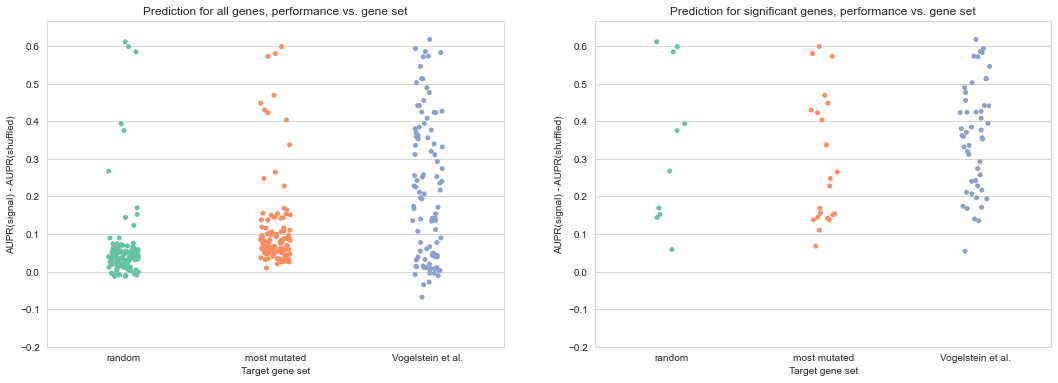

In [9]:
sns.set({'figure.figsize': (18, 6)})
sns.set_style('whitegrid')
# we want these colors to be different than the expression/methylation ones
sns.set_palette('Set2')
fig, axarr = plt.subplots(1, 2)

all_results_df.replace({'gene_set': gene_set_map}, inplace=True)

# plot mean performance over all genes in Vogelstein dataset
ax = axarr[0]
sns.stripplot(data=all_results_df, x='gene_set', y='delta_mean', ax=ax)
ax.set_title('Prediction for all genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))

# plot mean performance for genes that are significant for at least one data type
ax = axarr[1]
gene_list = all_results_df[all_results_df.reject_null == True].gene.unique()
print(gene_list.shape)
print(gene_list)
sns.stripplot(data=all_results_df[all_results_df.gene.isin(gene_list)],
              x='gene_set', y='delta_mean', ax=ax)
ax.set_title('Prediction for significant genes, performance vs. gene set')
ax.set_xlabel('Target gene set')
ax.set_ylabel('AUPR(signal) - AUPR(shuffled)')
ax.set_ylim(-0.2, max(all_results_df.delta_mean + 0.05))